# FLUA NUTRIÇÃO

## Job 1: Análise de efetividade de contatos pós-falta

#### Resumo
O objetivo desse notebook é analisar a efetividade dos contatos realizados por chat e por e-mail aos pacientes que faltaram à consulta. A comparação é feita usando dois grupos de pacientes: o grupo intervenção (GI) recebeu um contato da nutricionista incentivando-o a agendar e comparecer a outra consulta; o grupo controle (GC) não recebeu esse contato. A hipótese é que o grupo intervenção, após receber o contato, apresentou maiores taxas de novos agendamentos e realização de consultas do que o grupo controle, dentro do mesmo período de tempo analisado.

### Preparando o notebook


In [1]:
import pandas as pd
import numpy as np

In [2]:
# carregando o banco de dados de um arquivo Excel, camada Bronze 0 que indica que é o banco original
df_b0 = pd.read_excel('Flua_job1_datasetv1.xlsx', sheet_name='Banco compilado')

### Parte 1 - Limpeza dos dados

In [3]:
#checando os nomes das colunas originais
df_b0.columns

Index(['Data ', 'Mês', 'Ano', 'Nutri ', 'ID caso', 'Pessoa ',
       'Consulta (1,2,3,4,5,6)', 'Objetivo da pessoa',
       'Atendimento em outra língua? \n(português/ libras/ inglês)',
       'Status atendimento \n(Realizado, Falta, Reagendou)',
       'Engajamento\n(chat / e-mail ) ',
       'Mensagem Enviada\n(padrão ou pesonalizada com ou sem material )',
       'Engajamento deu certo? \n(Agendou/ Realizou/ Não voltou)',
       'Encerramento de caso', 'OBS'],
      dtype='object')

In [4]:
#criando um novo dataframe para trabalhar, camada Bronze 1, que é o mesmo banco de dados, apenas com as variáveis renomeadas
df_b1 = df_b0.rename(columns={'Data ': 'DATA',
                               'Mês': 'MES',
                               'Ano': 'ANO',
                               'Nutri ': 'NUTRICIONISTA',
                               'ID caso': 'ID_CASO',
                               'Pessoa ': 'PACIENTE_NOME',
                               'Consulta (1,2,3,4,5,6)': 'CONSULTA_ESTAGIO',
                               'Objetivo da pessoa': 'OBJETIVO_PACIENTE',
                               'Atendimento em outra língua? \n(português/ libras/ inglês)': 'IDIOMA',
                               'Status atendimento \n(Realizado, Falta, Reagendou)': 'STATUS_ATENDIMENTO',
                               'Engajamento\n(chat / e-mail ) ': 'ENGAJAMENTO_STATUS',
                               'Mensagem Enviada\n(padrão ou pesonalizada com ou sem material )': 'MENSAGEM_ENVIADA',
                               'Engajamento deu certo? \n(Agendou/ Realizou/ Não voltou)': 'ENGAJAMENTO_DESFECHO',
                               'Encerramento de caso': 'ENCERRAMENTO_CASO',
                               'OBS': 'OBSERVACOES'})
df_b1.columns
                               
                                
                              

Index(['DATA', 'MES', 'ANO', 'NUTRICIONISTA', 'ID_CASO', 'PACIENTE_NOME',
       'CONSULTA_ESTAGIO', 'OBJETIVO_PACIENTE', 'IDIOMA', 'STATUS_ATENDIMENTO',
       'ENGAJAMENTO_STATUS', 'MENSAGEM_ENVIADA', 'ENGAJAMENTO_DESFECHO',
       'ENCERRAMENTO_CASO', 'OBSERVACOES'],
      dtype='object')

In [5]:
# vendo informações do banco de dados
df_b1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2071 entries, 0 to 2070
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   DATA                  2071 non-null   datetime64[ns]
 1   MES                   2071 non-null   int64         
 2   ANO                   2071 non-null   int64         
 3   NUTRICIONISTA         2071 non-null   object        
 4   ID_CASO               1745 non-null   object        
 5   PACIENTE_NOME         2071 non-null   object        
 6   CONSULTA_ESTAGIO      2071 non-null   int64         
 7   OBJETIVO_PACIENTE     1299 non-null   object        
 8   IDIOMA                1451 non-null   object        
 9   STATUS_ATENDIMENTO    2071 non-null   object        
 10  ENGAJAMENTO_STATUS    263 non-null    object        
 11  MENSAGEM_ENVIADA      240 non-null    object        
 12  ENGAJAMENTO_DESFECHO  233 non-null    object        
 13  ENCERRAMENTO_CASO 

In [6]:
# checando os valores únicos de cada coluna
df_b1.nunique()

DATA                     217
MES                       13
ANO                        4
NUTRICIONISTA              7
ID_CASO                 1080
PACIENTE_NOME           1324
CONSULTA_ESTAGIO           6
OBJETIVO_PACIENTE         30
IDIOMA                     4
STATUS_ATENDIMENTO         5
ENGAJAMENTO_STATUS        10
MENSAGEM_ENVIADA          19
ENGAJAMENTO_DESFECHO       6
ENCERRAMENTO_CASO         18
OBSERVACOES               55
dtype: int64

In [7]:
#checando dados faltantes
df_b1.isnull().sum()

DATA                       0
MES                        0
ANO                        0
NUTRICIONISTA              0
ID_CASO                  326
PACIENTE_NOME              0
CONSULTA_ESTAGIO           0
OBJETIVO_PACIENTE        772
IDIOMA                   620
STATUS_ATENDIMENTO         0
ENGAJAMENTO_STATUS      1808
MENSAGEM_ENVIADA        1831
ENGAJAMENTO_DESFECHO    1838
ENCERRAMENTO_CASO       1595
OBSERVACOES             1968
dtype: int64

In [8]:
#tratando a variável DATA
df_b1['DATA'] = pd.to_datetime(df_b1['DATA'], errors='coerce')

# refazer as variáveis de mês e ano
df_b1['MES'] = df_b1['DATA'].dt.month   # extrai o mês da data
df_b1['ANO'] = df_b1['DATA'].dt.year     # extrai o ano da


In [9]:
# tratatando a variável ID_CASO

# trasnformando a variável ID_CASO em string
df_b1['ID_CASO'] = df_b1['ID_CASO'].astype(str)

# transformando os valores vazios em NaN
df_b1['ID_CASO'] = df_b1['ID_CASO'].replace('', np.nan)

# transformando os valores que contem "/" em NaN
df_b1['ID_CASO'] = df_b1['ID_CASO'].replace('3098-03-10 00:00:00', np.nan)

# transformando a variável ID_CASO em inteiro e transformando os valores NaN em missing
df_b1['ID_CASO'] = pd.to_numeric(df_b1['ID_CASO'], errors='coerce')

# retirando os decimais dos valores da variável ID_CASO
df_b1['ID_CASO'] = df_b1['ID_CASO'].astype('Int64')

In [10]:
# tratando a variável CONSULTA_ESTAGIO

# transformando os valores em inteiros
df_b1['CONSULTA_ESTAGIO'] = pd.to_numeric(df_b1['CONSULTA_ESTAGIO'], errors='coerce')

#retirando os decimais dos valores da variável CONSULTA_ESTAGIO
df_b1['CONSULTA_ESTAGIO'] = df_b1['CONSULTA_ESTAGIO'].astype('Int64')

# contar os valores da variável CONSULTA_ESTAGIO
df_b1['CONSULTA_ESTAGIO'].value_counts()

#calcular o percentual de valores
df_b1['CONSULTA_ESTAGIO'].value_counts(normalize=True, dropna=False)


CONSULTA_ESTAGIO
1    0.641719
2    0.230324
3    0.079189
4    0.028006
5     0.01352
6    0.007243
Name: proportion, dtype: Float64

In [11]:
# tratando a variável OBJETIVO_PACIENTE

# checando valores únicos
df_b1['OBJETIVO_PACIENTE'].unique()

# reorganizando os valores da variável OBJETIVO_PACIENTE em outra coluna chamada OBJETIVO_PACIENTE_RC
df_b1['OBJETIVO_PACIENTE_RC'] = df_b1['OBJETIVO_PACIENTE'].replace({'Perda de Peso': 'Emagrecimento',
                                                                    'Perda de peso ': 'Emagrecimento',
                                                                    'Perda de peso': 'Emagrecimento',
                                                                    'Emagrecimento ': 'Emagrecimento',
                                                                    'QV': 'Qualidade de Vida',
                                                                    'Reeducação alimentar': 'Qualidade de Vida',
                                                                    'Bariátrica': 'Cirurgia Bariatrica',
                                                                    'Perda de Peso/Bariátrica': 'Cirurgia Bariatrica',
                                                                    'Perda de peso/Bariátrica': 'Cirurgia Bariatrica',
                                                                    'Saúde da mulher ': 'Saude da Mulher',
                                                                    'TA': 'Transtorno Alimentar',
                                                                    'Saúde gástrica e intestinal': 'Saude Gastrica e Intestinal',
                                                                    'intestinal ': 'Saude Gastrica e Intestinal',
                                                                    'Intestinal ': 'Saude Gastrica e Intestinal',
                                                                    'Instestinal': 'Saude Gastrica e Intestinal',
                                                                    'Alergias alimentares ': 'Alergias Alimentares',
                                                                    'Comer emocional': 'Comer Emocional',
                                                                    'Comer emocional ': 'Comer Emocional',
                                                                    'Comportamental': 'Comer Emocional',
                                                                    'vegetarianismo': 'Vegetarianismo',
                                                                    'Vegetarianismo': 'Vegetarianismo',
                                                                    'Vegetariano': 'Vegetarianismo',
                                                                    'sem dado': 'Nao informado',
                                                                    'Esportivo': 'Nutricao Esportiva',
                                                                    'Infantil': 'Nutricao Infantil', 
                                                                    'Gestação': 'Nutricao na Gestacao',
                                                                    'Gestante': 'Nutricao na Gestacao',
                                                                    'Perda de peso/SOP': 'Sindrome do Ovario Policistico',
                                                                    'SOP': 'Sindrome do Ovario Policistico'})          


# contando valores únicos
df_b1['OBJETIVO_PACIENTE_RC'].value_counts(normalize=True, dropna=False)                                        

OBJETIVO_PACIENTE_RC
NaN                               0.372767
Emagrecimento                     0.335587
Qualidade de Vida                 0.093675
Nutricao Esportiva                0.069049
Outros                            0.029937
Comer Emocional                   0.015451
Transtorno Alimentar              0.012554
Nao informado                     0.011106
Saude Gastrica e Intestinal       0.010140
Nutricao na Gestacao              0.009657
Cirurgia Bariatrica               0.009174
Nutricao Infantil                 0.008691
Saude da Mulher                   0.007726
Alergias Alimentares              0.007243
Vegetarianismo                    0.006277
Sindrome do Ovario Policistico    0.000966
Name: proportion, dtype: float64

In [12]:
# tratando a variável IDIOMA

# reorganizando os valores da variável IDIOMA em outra coluna chamada IDIOMA_RC

# criando as condições para a variável IDIOMA_RC
conditions = [
    df_b1['IDIOMA'].isin(['Português', 'Portugês', 'Português ', 'Portugues']),
    df_b1['IDIOMA'] == 'Inglês',
    df_b1['IDIOMA'] == 'Libras',
    df_b1['IDIOMA'].isnull()
]

# valores correspondentes para cada condição
values = ['Portugues', 'Ingles', 'Libras', None]

# aplicando np.select para criar a nova variável IDIOMA_RC
df_b1['IDIOMA_RC'] = np.select(conditions, values, default=np.nan)

# contando os valores da nova variável IDIOMA_RC
df_b1['IDIOMA_RC'].value_counts(normalize=True, dropna=False)

IDIOMA_RC
Portugues    0.700628
None         0.299372
Name: proportion, dtype: float64

In [13]:
df_b1['STATUS_ATENDIMENTO'].value_counts()

STATUS_ATENDIMENTO
Realizado     1080
Falta          963
Reagendou       13
Reagendou       13
Desmarcou        2
Name: count, dtype: int64

In [14]:
# tratando a variável STATUS_ATENDIMENTO

# reorganizando os valores da variável STATUS_ATENDIMENTO em outra coluna chamada STATUS_ATENDIMENTO_RC usando np.select
conditions = [
    df_b1['STATUS_ATENDIMENTO'].isin(['Reagendou', 'Reagendou ']),
    df_b1['STATUS_ATENDIMENTO'].isin(['Falta', 'Falta ']),
    df_b1['STATUS_ATENDIMENTO'].isin(['Realizado', 'Realizado ']),
    df_b1['STATUS_ATENDIMENTO'].isin(['Desmarcou', 'Desmarcou ']),
    df_b1['STATUS_ATENDIMENTO'].isin(['', 'nan', 'NaN']),
    df_b1['STATUS_ATENDIMENTO'].isnull()
]

# valores correspondentes para cada condição
values = ['Reagendou', 'Falta', 'Realizado', 'Desmarcou', None, None]

# aplicando np.select para criar a nova variável STATUS_ATENDIMENTO_RC
df_b1['STATUS_ATENDIMENTO_RC'] = np.select(conditions, values, default=np.nan)

# contando os valores da nova variável STATUS_ATENDIMENTO_RC
df_b1['STATUS_ATENDIMENTO_RC'].value_counts(dropna=True)



STATUS_ATENDIMENTO_RC
Realizado    1080
Falta         963
Reagendou      26
Desmarcou       2
Name: count, dtype: int64

In [15]:
#tratando a variável ENGAJAMENTO_STATUS

# criando as condições para a variável ENGAJAMENTO_STATUS_RC
conditions_engajamento = [
    df_b1['ENGAJAMENTO_STATUS'].isin(['WhatsApp']),
    df_b1['ENGAJAMENTO_STATUS'].isin(['chat', 'chat ', 'Chat']),
    df_b1['ENGAJAMENTO_STATUS'].isin(['NÃO REALIZADO']),
    df_b1['ENGAJAMENTO_STATUS'].isin(['Email']),
    df_b1['ENGAJAMENTO_STATUS'].isin(['letramos@br.ibm.com ', 'gabriellaferreirapaiva@gmail.com', 
                                      'brunoromulo@hotmail.com', 'lorrainegg4@gmail.com', 'NaN', np.nan])
]

# valores correspondentes para cada condição
values_engajamento = ['WhatsApp', 'Chat', 'Nao realizado', 'Email', None]

# aplicando np.select para criar a nova variável ENGAJAMENTO_STATUS_RC
df_b1['ENGAJAMENTO_STATUS_RC'] = np.select(conditions_engajamento, values_engajamento, default=np.nan)

df_b1['ENGAJAMENTO_STATUS_RC'].value_counts(dropna=True)

ENGAJAMENTO_STATUS_RC
Chat             234
Nao realizado     15
Email              9
WhatsApp           1
Name: count, dtype: int64

In [16]:
# Tratando a variável MENSAGEM_ENVIADA

# criando as condições para a variável MENSAGEM_ENVIADA_RC
conditions_mensagem = [
    df_b1['MENSAGEM_ENVIADA'].isin(['Personalizada s/ material ', 'Personalizada', 
                                    'Personalizada sem material', 'Personalizado sem material ', 
                                    'personalizado sem material']),
    df_b1['MENSAGEM_ENVIADA'].isin(['padrão s/ material  ', 'Padrão']),
    df_b1['MENSAGEM_ENVIADA'].isin(['padrão c/ material ', 'Padrão com material ', 
                                    'Padrão com material', 'padrao com material', 
                                    'personalizada com material', 'padrão com material ', 
                                    'padrão com material', 'padrão com material (C2): ', 
                                    'padrão com material (C2)']),
    df_b1['MENSAGEM_ENVIADA'].isin(['Personalizada com material']),
    df_b1['MENSAGEM_ENVIADA'].isin(['NaN', 'nan', np.nan]),
    df_b1['MENSAGEM_ENVIADA'].isnull()
]

# valores correspondentes para cada condição
values_mensagem = [
    'Personalizada',
    'Padrao',
    'Padrao com material',
    'Personalizada com material',
    None,
    None
]

# aplicando np.select para criar a nova variável MENSAGEM_ENVIADA_RC
df_b1['MENSAGEM_ENVIADA_RC'] = np.select(conditions_mensagem, values_mensagem, default=np.nan)

# verificando os valores únicos da nova variável
#df_b1['MENSAGEM_ENVIADA_RC'].unique()
                   
df_b1['MENSAGEM_ENVIADA_RC'].value_counts(dropna=True)

MENSAGEM_ENVIADA_RC
Padrao com material           122
Padrao                         80
Personalizada                  16
Personalizada com material      1
Name: count, dtype: int64

In [17]:
# Criando a variável INTERVENCAO a partir das variáveis MENSAGEM_ENVIADA_RC
df_b1['INTERVENCAO'] = df_b1['MENSAGEM_ENVIADA_RC'].replace({'Personalizada': 1,
                                                              'Padrao': 1,
                                                              'Padrao com material': 1,
                                                              'Personalizada com material': 1,
                                                              None: 0,
                                                              np.nan: 0})

# contando os valores da nova variável INTERVENCAO
df_b1['INTERVENCAO'].value_counts(dropna=False)

/tmp/ipykernel_16289/2784136694.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_b1['INTERVENCAO'] = df_b1['MENSAGEM_ENVIADA_RC'].replace({'Personalizada': 1,


INTERVENCAO
0.0    1852
1.0     219
Name: count, dtype: int64

In [18]:
# tratando a variável ENGAJAMENTO_DESFECHO

# criando as condições para a variável ENGAJAMENTO_DESFECHO_RC
conditions_desfecho = [
    df_b1['ENGAJAMENTO_DESFECHO'].isin(['Agendou', 'Agendou ', 'Agendou']),
    df_b1['ENGAJAMENTO_DESFECHO'].isin(['Realizou', 'Realizou ', 'Realizou']),
    df_b1['ENGAJAMENTO_DESFECHO'].isin(['Não voltou', 'Não voltou ', 'Não voltou']),
    df_b1['ENGAJAMENTO_DESFECHO'].isin(['Não agendou', 'Não agendou ', 'Não agendou']),
    df_b1['ENGAJAMENTO_DESFECHO'].isin(['nan', 'nan ', 'nan']),
    df_b1['ENGAJAMENTO_DESFECHO'] == np.nan,
    df_b1['ENGAJAMENTO_DESFECHO'] == 0
]

# valores correspondentes para cada condição
values_desfecho = ['Agendou', 'Realizou', 'Nao voltou', 'Nao agendou', None, None, None]

# aplicando np.select para criar a nova variável ENGAJAMENTO_DESFECHO_RC
df_b1['ENGAJAMENTO_DESFECHO_RC'] = np.select(conditions_desfecho, values_desfecho, default=np.nan)

# contando os valores da nova variável ENGAJAMENTO_DESFECHO_RC
df_b1['ENGAJAMENTO_DESFECHO_RC'].value_counts()


ENGAJAMENTO_DESFECHO_RC
Nao voltou     155
Realizou        40
Agendou         17
Nao agendou     16
Name: count, dtype: int64

In [19]:
# Tratando a variável ENCERRAMENTO_CASO

# criando as condições para a variável ENCERRAMENTO_CASO_RC
conditions_encerramento = [
    df_b1['ENCERRAMENTO_CASO'].isin(['Encerrado', 'Encerrado ', 'Encerrado', 'encerrado ', 'encerrado', 
                                     'sim', 'Sim' 'Encerrou o caso',  'Caso encerrado', 'Encerrou', 'Encerrou ',
                                     'Caso encerrado pela pessoa', 'Encerramento de caso', 'cancelou programa', 
                                     'Encerrou  no dia da consulta']),
    df_b1['ENCERRAMENTO_CASO'].isin(['Concluiu o acompanhamento', 'Finalizou o acompanhamento']),
    df_b1['ENCERRAMENTO_CASO'].isin(['Tentativa de reengajar']),
    df_b1['ENCERRAMENTO_CASO'].isin(['nan', 'nan ', 'nan', '-']),
    df_b1['ENCERRAMENTO_CASO'] == 0
]

# valores correspondentes para cada condição
values_encerramento = ['Caso encerrado', 'Concluiu o programa', 'Tentativa de reengajar', None, None]

# aplicando np.select para criar a nova variável ENCERRAMENTO_CASO_RC
df_b1['ENCERRAMENTO_CASO_RC'] = np.select(conditions_encerramento, values_encerramento, default=np.nan)



# contando os valores da nova variável ENCERRAMENTO_CASO_RC
df_b1['ENCERRAMENTO_CASO_RC'].value_counts()

ENCERRAMENTO_CASO_RC
Caso encerrado            458
Concluiu o programa         3
Tentativa de reengajar      1
Name: count, dtype: int64

In [20]:
# tratando a variável OBSERVACOES
# interessa-nos apenas os casos que encerraram ou concluíram o tratamento e não foram devidamente contabilizados anteriormente

# criando as condições para a variável OBSERVACOES
conditions_observacoes = [
    df_b1['OBSERVACOES'].isin(['Paciente encerrou o caso no dia ', 'Paciente encerrou o caso',
                               'Paciente encerrou caso', 'Encerrou o caso', 'Pct encerrou',
                               'Caso encerrado', 'Encerrou 1h antes da consulta',
                               'Encerrou 25min antes da consulta',
                               'Encerrou 4h antes da consulta',
                               'Paciente encerrou o caso com menosde 24hrs antes da consulta']),
    df_b1['OBSERVACOES'].isin(['alta!', 'Última consulta. Enviei email. ', 'Última consulta'])
]

# valores correspondentes para cada condição
values_observacoes = ['Caso encerrado', 'Concluiu o programa']

# aplicando np.select para criar a nova variável OBSERVACOES_RC
df_b1['OBSERVACOES_RC'] = np.select(conditions_observacoes, values_observacoes, default=None)


#df_b1['OBSERVACOES_RC'].replace('nan', np.nan, inplace=True)


In [21]:
# criando a variável ENCERRAMENTO_CASO_RC2

# fazendo um merge entre as variáveis ENCERRAMENTO_CASO_RC e OBSERVACOES_RC
df_b1['ENCERRAMENTO_CASO_RC2'] = df_b1['ENCERRAMENTO_CASO_RC']
df_b1['ENCERRAMENTO_CASO_RC2'] = df_b1['ENCERRAMENTO_CASO_RC'].fillna(df_b1['OBSERVACOES_RC'])


# trazendo os casos encerrados da coluna OBSERVACOES para a coluna ENCERRAMENTO_CASO_RC2
df_b1['ENCERRAMENTO_CASO_RC2'] = np.where(
    df_b1['OBSERVACOES_RC'] == 'Caso encerrado',  # Condição
    'Caso encerrado',                            # Valor se a condição for verdadeira
    df_b1['ENCERRAMENTO_CASO_RC']                # Caso contrário, mantém o valor original de ENCERRAMENTO_CASO_RC
)


# trazendo os casos encerrados da coluna OBSERVACOESCONSULTA_ESTAGIO para a coluna ENCERRAMENTO_CASO_RC2
df_b1['ENCERRAMENTO_CASO_RC2'] = np.where(
    df_b1['CONSULTA_ESTAGIO'] == 6,  # Condição
    'Caso encerrado',                # Valor se a condição for verdadeira
    df_b1['ENCERRAMENTO_CASO_RC']    # Caso contrário, mantém o valor original de ENCERRAMENTO_CASO_RC
)


# ajustando os valores da variável ENCERRAMENTO_CASO_RC2
df_b1['ENCERRAMENTO_CASO_RC2'] = df_b1['ENCERRAMENTO_CASO_RC2'].replace({None: np.nan})


# Verificando os valores únicos da nova variável
df_b1['ENCERRAMENTO_CASO_RC2'].value_counts(dropna=True)

ENCERRAMENTO_CASO_RC2
Caso encerrado            470
Concluiu o programa         3
Tentativa de reengajar      1
Name: count, dtype: int64

In [22]:
df_b1['OBSERVACOES_RC'].value_counts(dropna=True)

OBSERVACOES_RC
Caso encerrado         19
Concluiu o programa     3
Name: count, dtype: int64

In [23]:
# Reordenando as colunas
df_b1 = df_b1[['DATA', 
               'MES', 
               'ANO', 
               'NUTRICIONISTA', 
               'ID_CASO', 
               'PACIENTE_NOME', 
               'CONSULTA_ESTAGIO', 
               'OBJETIVO_PACIENTE', 
               'OBJETIVO_PACIENTE_RC', 
               'IDIOMA', 
               'IDIOMA_RC',
               'STATUS_ATENDIMENTO',
               'STATUS_ATENDIMENTO_RC',	 
               'ENGAJAMENTO_STATUS',
               'ENGAJAMENTO_STATUS_RC',
               'INTERVENCAO', 
               'MENSAGEM_ENVIADA',
               'MENSAGEM_ENVIADA_RC', 
               'ENGAJAMENTO_DESFECHO',
               'ENGAJAMENTO_DESFECHO_RC', 
               'ENCERRAMENTO_CASO',
               'ENCERRAMENTO_CASO_RC', 
               'OBSERVACOES',
               'OBSERVACOES_RC']]

df_b1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2071 entries, 0 to 2070
Data columns (total 24 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   DATA                     2071 non-null   datetime64[ns]
 1   MES                      2071 non-null   int32         
 2   ANO                      2071 non-null   int32         
 3   NUTRICIONISTA            2071 non-null   object        
 4   ID_CASO                  1741 non-null   Int64         
 5   PACIENTE_NOME            2071 non-null   object        
 6   CONSULTA_ESTAGIO         2071 non-null   Int64         
 7   OBJETIVO_PACIENTE        1299 non-null   object        
 8   OBJETIVO_PACIENTE_RC     1299 non-null   object        
 9   IDIOMA                   1451 non-null   object        
 10  IDIOMA_RC                1451 non-null   object        
 11  STATUS_ATENDIMENTO       2071 non-null   object        
 12  STATUS_ATENDIMENTO_RC    2071 non-

In [24]:
# checando a posição 
df_b1.loc[657] 

DATA                                     2024-06-26 00:00:00
MES                                                        6
ANO                                                     2024
NUTRICIONISTA                                          Clara
ID_CASO                                                 <NA>
PACIENTE_NOME              Mariana Campideli Teixeira  Silva
CONSULTA_ESTAGIO                                           1
OBJETIVO_PACIENTE                                        NaN
OBJETIVO_PACIENTE_RC                                     NaN
IDIOMA                                                   NaN
IDIOMA_RC                                               None
STATUS_ATENDIMENTO                                 Realizado
STATUS_ATENDIMENTO_RC                              Realizado
ENGAJAMENTO_STATUS                                       NaN
ENGAJAMENTO_STATUS_RC                                   None
INTERVENCAO                                              0.0
MENSAGEM_ENVIADA        

In [25]:
# filtrar todas as linhas com PACIENTE_NOME "Mariana Campideli Teixeira  Silva" ou "Mariana Campideli Teixeira Silva", mostrar a linha inteira
filtro1 = df_b1[df_b1['PACIENTE_NOME'].str.contains('Mariana Campideli Teixeira  Silva|Mariana Campideli Teixeira Silva', na=False)]

#filtro1 = df_b1[df_b1['PACIENTE_NOME'] == 'Mariana Campideli Teixeira  Silva','Mariana Campideli Teixeira Silva' ]
filtro1

,DATA,MES,ANO,NUTRICIONISTA,ID_CASO,PACIENTE_NOME,CONSULTA_ESTAGIO,OBJETIVO_PACIENTE,OBJETIVO_PACIENTE_RC,IDIOMA,...,ENGAJAMENTO_STATUS_RC,INTERVENCAO,MENSAGEM_ENVIADA,MENSAGEM_ENVIADA_RC,ENGAJAMENTO_DESFECHO,ENGAJAMENTO_DESFECHO_RC,ENCERRAMENTO_CASO,ENCERRAMENTO_CASO_RC,OBSERVACOES,OBSERVACOES_RC
2,2024-02-27,2,2024,Ana Luisa,407911,Mariana Campideli Teixeira Silva,1,QV,Qualidade de Vida,Português,...,None,0.0,NaN,None,NaN,NaN,encerrado,Caso encerrado,NaN,None
14,2024-03-14,3,2024,Ana Luisa,407911,Mariana Campideli Teixeira Silva,2,QV,Qualidade de Vida,Português,...,None,0.0,NaN,None,NaN,NaN,encerrado,Caso encerrado,NaN,None
19,2024-03-25,3,2024,Ana Luisa,407911,Mariana Campideli Teixeira Silva,3,QV,Qualidade de Vida,Português,...,None,0.0,NaN,None,NaN,NaN,encerrado,Caso encerrado,NaN,None
54,2024-04-22,4,2024,Ana Luisa,407911,Mariana Campideli Teixeira Silva,4,QV,Qualidade de Vida,Português,...,None,0.0,NaN,None,NaN,NaN,encerrado,Caso encerrado,NaN,None
68,2024-05-06,5,2024,Ana Luisa,407911,Mariana Campideli Teixeira Silva,5,QV,Qualidade de Vida,Português,...,None,0.0,NaN,None,NaN,NaN,encerrado,Caso encerrado,NaN,None
657,2024-06-26,6,2024,Clara,<NA>,Mariana Campideli Teixeira Silva,1,NaN,NaN,NaN,...,None,0.0,NaN,None,NaN,NaN,NaN,NaN,NaN,None
675,2024-07-08,7,2024,Clara,<NA>,Mariana Campideli Teixeira Silva,2,NaN,NaN,NaN,...,None,0.0,NaN,None,NaN,NaN,NaN,NaN,NaN,None
694,2024-07-18,7,2024,Clara,<NA>,Mariana Campideli Teixeira Silva,2,NaN,NaN,NaN,...,None,0.0,NaN,None,NaN,NaN,NaN,NaN,NaN,None
759,2024-08-15,8,2024,Clara,<NA>,Mariana Campideli Teixeira Silva,3,NaN,NaN,NaN,...,None,0.0,NaN,None,NaN,NaN,NaN,NaN,NaN,None
800,2024-09-05,9,2024,Clara,437631,Mariana Campideli Teixeira Silva,4,NaN,NaN,NaN,...,None,0.0,NaN,None,NaN,NaN,NaN,NaN,NaN,None


## Para depois: tratar a variável NOME

import hashlib

# Função para normalizar o nome do paciente
def normalize_name(name):
    # Remover espaços extras, acentuação e converter para minúsculas
    name = name.strip().lower()
    # Você pode adicionar mais regras de normalização aqui se necessário
    return name

# Função para criar um ID único baseado no nome
def create_unique_id(name):
    normalized_name = normalize_name(name)
    # Usar hashlib para gerar um hash MD5 do nome normalizado
    unique_id = hashlib.md5(normalized_name.encode()).hexdigest()
    return unique_id

# Exemplo de uso com uma lista de nomes de pacientes
patients = [
    "João Silva",
    "joão silva",
    "Jõao Silvá",
    "Joana da Silva",
    "joana dasilva"
]

# Criar um dicionário para armazenar os IDs únicos
patient_ids = {}

for patient in patients:
    unique_id = create_unique_id(patient)
    if unique_id not in patient_ids.values():
        # Se o ID único ainda não existe, adicione-o ao dicionário
        patient_ids[unique_id] = patient
    else:
        # Se já existir um paciente com esse nome (mesmo erro de grafia), você pode decidir como lidar
        print(f"Nome '{patient}' já tem um ID único: {unique_id}")

# Exibir os IDs únicos criados para cada paciente
for unique_id, name in patient_ids.items():
    print(f"ID Paciente: {unique_id}, Nome: {name}")


In [26]:
import difflib

# Função para normalizar o nome do paciente
def normalize_name(name):
    # Remover espaços extras, acentuação e converter para minúsculas
    name = name.strip().lower()
    return name

# Função para calcular a porcentagem de similaridade entre dois nomes
def similarity(name1, name2):
    normalized_name1 = normalize_name(name1)
    normalized_name2 = normalize_name(name2)
    return difflib.SequenceMatcher(None, normalized_name1, normalized_name2).ratio()

# Exemplo de uso com uma lista de nomes de pacientes
patients = [
    "João Silva",
    "joão silva",
    "Jõao Silvá",
    "Joana da Silva",
    "joana dasilva"
]

# Define o nível mínimo de similaridade (0 a 1)
min_similarity_threshold = 0.8

# Criar um dicionário para armazenar grupos de nomes semelhantes
similar_groups = {}

for i, patient in enumerate(patients):
    found_group = False
    for group_id, group in similar_groups.items():
        if similarity(patient, group[0]) >= min_similarity_threshold:
            group.append(patient)
            found_group = True
            break
    
    # Se não encontrou um grupo adequado, cria um novo grupo
    if not found_group:
        similar_groups[i] = [patient]

# Exibir os grupos de nomes semelhantes
for group_id, group in similar_groups.items():
    print(f"Grupo {group_id+1}:")
    for name in group:
        print(f"  - {name}")


Grupo 1:
  - João Silva
  - joão silva
Grupo 3:
  - Jõao Silvá
Grupo 4:
  - Joana da Silva
  - joana dasilva


In [27]:
# prompt: faça uma chave única composta em formato de hash junto ID_CASO e NOME e coloque isso em outra coluna ID_CASO_NOME

import hashlib

# Ensure 'ID_CASO' and 'PACIENTE_NOME' are strings to avoid type errors during concatenation
df_b1['ID_CASO_STR'] = df_b1['ID_CASO'].astype(str).fillna('')
df_b1['PACIENTE_NOME_STR'] = df_b1['PACIENTE_NOME'].astype(str).fillna('')

# Concatenate 'ID_CASO_STR' and 'PACIENTE_NOME_STR' and apply the hash function
df_b1['ID_CASO_NOME'] = (df_b1['ID_CASO_STR'] + '_' + df_b1['PACIENTE_NOME_STR']).apply(
    lambda x: hashlib.md5(x.encode()).hexdigest()
)

# Drop the temporary string columns if you don't need them
df_b1 = df_b1.drop(columns=['ID_CASO_STR', 'PACIENTE_NOME_STR'])

# Display the first few rows with the new column
print(df_b1[['ID_CASO', 'PACIENTE_NOME', 'ID_CASO_NOME']].head())

   ID_CASO                      PACIENTE_NOME  \
0   408222                 Samira Alves Vitor   
1   408015            Patrícia Alves Pinheiro   
2   407911  Mariana Campideli Teixeira Silva    
3   408854  SUELEN DELGADO MONTEIRO DE CASTRO   
4   408052    Thayna Maria Gonçalves Carvalho   

                       ID_CASO_NOME  
0  859ad6ed185e037c1491bb7b76756ece  
1  a0c17fdf33308ea5de98033090c03a80  
2  e60f5a72d4723adab174e1acddf61836  
3  5b569cdc6ff5c18a9f954be8878929a3  
4  c50cbdf219aa10a6367d88741705d13e  


In [28]:
# prompt: faça uma chave única composta em formato de hash junto ID_CASO e PACIENTE_NOME em uma outra coluna ID_CASO_NOME2 e usando uma hash mais curta de até 10 dígitos

# Generate a new column 'ID_CASO_NOME2' with a shorter hash
df_b1['ID_CASO_NOME2'] = (df_b1['ID_CASO'].astype(str).fillna('') + '_' + df_b1['PACIENTE_NOME'].astype(str).fillna('')).apply(
    lambda x: hashlib.md5(x.encode()).hexdigest()[:10]  # Take the first 10 characters of the hash
)

# Display the first few rows with the new column
print(df_b1[['ID_CASO', 'PACIENTE_NOME', 'ID_CASO_NOME2']].head())

   ID_CASO                      PACIENTE_NOME ID_CASO_NOME2
0   408222                 Samira Alves Vitor    859ad6ed18
1   408015            Patrícia Alves Pinheiro    a0c17fdf33
2   407911  Mariana Campideli Teixeira Silva     e60f5a72d4
3   408854  SUELEN DELGADO MONTEIRO DE CASTRO    5b569cdc6f
4   408052    Thayna Maria Gonçalves Carvalho    c50cbdf219


In [29]:
# Agrupar por ID_CASO_NOME2, PACIENTE_NOME, ID_CASO, CONSULTA_ESTAGIO e contar o total de linhas
df_grouped = df_b1.groupby(['ID_CASO_NOME2', 'PACIENTE_NOME', 'ID_CASO', 'CONSULTA_ESTAGIO']).size().reset_index(name='Total de Consultas')

# Contar o total de faltas para cada grupo
df_faltas = df_b1[df_b1['STATUS_ATENDIMENTO_RC'] == 'Falta'].groupby(['ID_CASO_NOME2', 'PACIENTE_NOME', 'ID_CASO', 'CONSULTA_ESTAGIO']).size().reset_index(name='Total de Faltas')

# Contar o total de reagendamentos para cada grupo
df_reagendamentos = df_b1[df_b1['STATUS_ATENDIMENTO_RC'] == 'Reagendou'].groupby(['ID_CASO_NOME2', 'PACIENTE_NOME', 'ID_CASO', 'CONSULTA_ESTAGIO']).size().reset_index(name='Total de Reagendamentos')

# Juntar os dataframes
df_resultado = df_grouped.merge(df_faltas, on=['ID_CASO_NOME2', 'PACIENTE_NOME', 'ID_CASO', 'CONSULTA_ESTAGIO'], how='left')
df_resultado = df_resultado.merge(df_reagendamentos, on=['ID_CASO_NOME2', 'PACIENTE_NOME', 'ID_CASO', 'CONSULTA_ESTAGIO'], how='left')

# Preencher valores NaN com 0
df_resultado[['Total de Faltas', 'Total de Reagendamentos']] = df_resultado[['Total de Faltas', 'Total de Reagendamentos']].fillna(0).astype(int)

# Exibir a tabela resultante
df_resultado


,ID_CASO_NOME2,PACIENTE_NOME,ID_CASO,CONSULTA_ESTAGIO,Total de Consultas,Total de Faltas,Total de Reagendamentos
0,00026b164b,Diessyca,452113,1,1,1,0
1,009dfc0edc,Ana Paula Alves Aguiar,462994,1,1,1,0
2,00a4b4b021,Thamires Monik dos Santos Lima,459444,1,1,1,0
3,00d8cebffe,Letícia Liene Pasold,454303,1,1,1,0
4,0122f95397,Adriana de Paula Teixeira Mendes Franco,447280,1,1,0,0
...,...,...,...,...,...,...,...
1657,ffcccf423a,Mateus Oliva,455311,2,1,1,0
1658,ffe2765d9b,Beatriz Jessica Rocha Delpizzo,458818,1,1,1,0
1659,fff0ff3c5d,Patricia Angelim Paoi,456029,2,1,0,0
1660,fff0ff3c5d,Patricia Angelim Paoi,456029,3,1,0,0


In [30]:
df_b1.iloc[460]

DATA                                         2025-01-23 00:00:00
MES                                                            1
ANO                                                         2025
NUTRICIONISTA                                          Ana Luisa
ID_CASO                                                   461937
PACIENTE_NOME              Adrielli Thaís de Oliveira dos Santos
CONSULTA_ESTAGIO                                               1
OBJETIVO_PACIENTE                               Saúde da mulher 
OBJETIVO_PACIENTE_RC                             Saude da Mulher
IDIOMA                                                 Português
IDIOMA_RC                                              Portugues
STATUS_ATENDIMENTO                                     Realizado
STATUS_ATENDIMENTO_RC                                  Realizado
ENGAJAMENTO_STATUS                                           NaN
ENGAJAMENTO_STATUS_RC                                       None
INTERVENCAO              

In [31]:
filtro2 = df_b1[df_b1['ID_CASO'] == 446124]
filtro2

,DATA,MES,ANO,NUTRICIONISTA,ID_CASO,PACIENTE_NOME,CONSULTA_ESTAGIO,OBJETIVO_PACIENTE,OBJETIVO_PACIENTE_RC,IDIOMA,...,MENSAGEM_ENVIADA,MENSAGEM_ENVIADA_RC,ENGAJAMENTO_DESFECHO,ENGAJAMENTO_DESFECHO_RC,ENCERRAMENTO_CASO,ENCERRAMENTO_CASO_RC,OBSERVACOES,OBSERVACOES_RC,ID_CASO_NOME,ID_CASO_NOME2
828,2024-09-17,9,2024,Clara,446124,Marcio Jose Pizzato Pedroso,1,NaN,NaN,NaN,...,NaN,None,NaN,NaN,NaN,NaN,NaN,None,9c4c7a512f791e1984b47d62b9057ba5,9c4c7a512f
879,2024-10-02,10,2024,Clara,446124,Marcio José Pizzato Pedroso,2,NaN,NaN,NaN,...,NaN,None,NaN,NaN,NaN,NaN,NaN,None,ba3b74e1b9394126c6076b2fd21a8f83,ba3b74e1b9
960,2024-10-24,10,2024,Clara,446124,Marcio José Pizzato Pedroso,3,NaN,NaN,NaN,...,NaN,None,NaN,NaN,NaN,NaN,NaN,None,ba3b74e1b9394126c6076b2fd21a8f83,ba3b74e1b9
977,2024-10-29,10,2024,Clara,446124,Marcio José Pizzato Pedroso,4,NaN,NaN,NaN,...,NaN,None,NaN,NaN,NaN,NaN,NaN,None,ba3b74e1b9394126c6076b2fd21a8f83,ba3b74e1b9
1169,2024-12-18,12,2024,Clara,446124,Marcio Jose Pizzato Pedroso,5,Perda de peso,Emagrecimento,Português,...,Padrão,NaN,Realizou,Realizou,NaN,NaN,NaN,None,950dfd63981c80ec6aa19f0f1db2e6f9,950dfd6398
1225,2025-01-21,1,2025,Clara,446124,Marcio Pizzato,6,Perda de Peso,Emagrecimento,Português,...,NaN,None,NaN,NaN,Caso encerrado,Caso encerrado,Paciente faltou em último atendimento,None,f557d25a54961b1b0ebf9574c28d7bdd,f557d25a54


In [32]:
# prompt: Crie um novo dataframe chamado df_p2 que irá conter as variáveis do banco df_b1 da seguinte forma: Coluna 1 ID_CASO, Coluna 2 PACIENTE_NOME, Coluna 3 CONSULTA_ESTAGIO, Coluna 4 CONSULTAS_REALIZADAS, Coluna 5 FALTAS, Coluna 6 REAGENDAMENTOS

# Seleciona as colunas desejadas do dataframe df_b1 para criar df_p2
df_p2 = df_b1[['ID_CASO', 'PACIENTE_NOME', 'CONSULTA_ESTAGIO', 'STATUS_ATENDIMENTO_RC']].copy()

# Renomeia as colunas para os nomes especificados
df_p2 = df_p2.rename(columns={
    'STATUS_ATENDIMENTO_RC': 'STATUS_ATENDIMENTO'
})

# Calcula o total de consultas realizadas por paciente e estágio
df_realizadas = df_p2[df_p2['STATUS_ATENDIMENTO'] == 'Realizado'].groupby(['ID_CASO', 'PACIENTE_NOME', 'CONSULTA_ESTAGIO']).size().reset_index(name='CONSULTAS_REALIZADAS')

# Calcula o total de faltas por paciente e estágio
df_faltas = df_p2[df_p2['STATUS_ATENDIMENTO'] == 'Falta'].groupby(['ID_CASO', 'PACIENTE_NOME', 'CONSULTA_ESTAGIO']).size().reset_index(name='FALTAS')

# Calcula o total de reagendamentos por paciente e estágio
df_reagendamentos = df_p2[df_p2['STATUS_ATENDIMENTO'] == 'Reagendou'].groupby(['ID_CASO', 'PACIENTE_NOME', 'CONSULTA_ESTAGIO']).size().reset_index(name='REAGENDAMENTOS')

# Cria o dataframe final df_p2 juntando as informações
df_p2 = df_realizadas.merge(df_faltas, on=['ID_CASO', 'PACIENTE_NOME', 'CONSULTA_ESTAGIO'], how='left')
df_p2 = df_p2.merge(df_reagendamentos, on=['ID_CASO', 'PACIENTE_NOME', 'CONSULTA_ESTAGIO'], how='left')

# Preenche os valores NaN com 0 nas colunas de contagem
df_p2[['FALTAS', 'REAGENDAMENTOS']] = df_p2[['FALTAS', 'REAGENDAMENTOS']].fillna(0).astype(int)

# Reordena as colunas para a ordem desejada
df_p2 = df_p2[['ID_CASO', 'PACIENTE_NOME', 'CONSULTA_ESTAGIO', 'CONSULTAS_REALIZADAS', 'FALTAS', 'REAGENDAMENTOS']]

# Exibe as primeiras linhas do novo dataframe
print(df_p2.head())


   ID_CASO                      PACIENTE_NOME  CONSULTA_ESTAGIO  \
0   407911  Mariana Campideli Teixeira Silva                  1   
1   407911  Mariana Campideli Teixeira Silva                  2   
2   408015            Patrícia Alves Pinheiro                 1   
3   408015            Patrícia Alves Pinheiro                 2   
4   408015            Patrícia Alves Pinheiro                 3   

   CONSULTAS_REALIZADAS  FALTAS  REAGENDAMENTOS  
0                     1       0               0  
1                     1       0               0  
2                     1       0               0  
3                     1       0               0  
4                     1       0               0  


In [33]:
# prompt: create a new dataframe called df_p3 with the variables ID_CASO (int), PACIENTE_NOME (str), CONSULTA_ESTAGIO_MAX (int), TOTAL_REALIZADAS (int), TOTAL_FALTAS (int), TOTAL_REAGENDAMENTOS (int)

df_p3 = df_b1.groupby(['ID_CASO', 'PACIENTE_NOME']) \
    .agg(CONSULTA_ESTAGIO_MAX=('CONSULTA_ESTAGIO', 'max'),
         TOTAL_REALIZADAS=('STATUS_ATENDIMENTO_RC', lambda x: (x == 'Realizado').sum()),
         TOTAL_FALTAS=('STATUS_ATENDIMENTO_RC', lambda x: (x == 'Falta').sum()),
         TOTAL_REAGENDAMENTOS=('STATUS_ATENDIMENTO_RC', lambda x: (x == 'Reagendou').sum())
        ) \
    .reset_index()

# Ensure columns have the correct data types
df_p3['ID_CASO'] = df_p3['ID_CASO'].astype(int)
df_p3['PACIENTE_NOME'] = df_p3['PACIENTE_NOME'].astype(str)
df_p3['CONSULTA_ESTAGIO_MAX'] = df_p3['CONSULTA_ESTAGIO_MAX'].astype(int)
df_p3['TOTAL_REALIZADAS'] = df_p3['TOTAL_REALIZADAS'].astype(int)
df_p3['TOTAL_FALTAS'] = df_p3['TOTAL_FALTAS'].astype(int)
df_p3['TOTAL_REAGENDAMENTOS'] = df_p3['TOTAL_REAGENDAMENTOS'].astype(int)

print(df_p3.head())
print(df_p3.info())

   ID_CASO                      PACIENTE_NOME  CONSULTA_ESTAGIO_MAX  \
0    46202                     Lilian Gonçalo                     3   
1   407911   Mariana Campideli Teixeira Silva                     5   
2   407911  Mariana Campideli Teixeira Silva                      3   
3   408015            Patrícia Alves Pinheiro                     4   
4   408052    Thayna Maria Gonçalves Carvalho                     2   

   TOTAL_REALIZADAS  TOTAL_FALTAS  TOTAL_REAGENDAMENTOS  
0                 0             1                     0  
1                 0             2                     0  
2                 2             1                     0  
3                 3             1                     0  
4                 0             3                     0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1193 entries, 0 to 1192
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   ID_CASO       

In [34]:
df_p3 = df_b1.groupby(['ID_CASO']).agg(
    PACIENTE_NOME=('PACIENTE_NOME', 'first'),
    NUTRI = ('NUTRICIONISTA', 'last'),
    CONSULTA_ESTAGIO_MAX=('CONSULTA_ESTAGIO', 'max'),
    TOTAL_REALIZADAS=('STATUS_ATENDIMENTO_RC', lambda x: (x == 'Realizado').sum()),
    TOTAL_FALTAS=('STATUS_ATENDIMENTO_RC', lambda x: (x == 'Falta').sum()),
    TOTAL_REAGENDAMENTOS=('STATUS_ATENDIMENTO_RC', lambda x: (x == 'Reagendou').sum())
).reset_index()

# Ensure correct data types for the new columns
df_p3['ID_CASO'] = df_p3['ID_CASO'].astype(int)
df_p3['PACIENTE_NOME'] = df_p3['PACIENTE_NOME'].astype(str)
df_p3['NUTRI'] = df_p3['NUTRI'].astype(str)
df_p3['CONSULTA_ESTAGIO_MAX'] = df_p3['CONSULTA_ESTAGIO_MAX'].astype(int)
df_p3['TOTAL_REALIZADAS'] = df_p3['TOTAL_REALIZADAS'].astype(int)
df_p3['TOTAL_FALTAS'] = df_p3['TOTAL_FALTAS'].astype(int)
df_p3['TOTAL_REAGENDAMENTOS'] = df_p3['TOTAL_REAGENDAMENTOS'].astype(int)

df_p3.head()

,ID_CASO,PACIENTE_NOME,NUTRI,CONSULTA_ESTAGIO_MAX,TOTAL_REALIZADAS,TOTAL_FALTAS,TOTAL_REAGENDAMENTOS
0,46202,Lilian Gonçalo,Clara,3,0,1,0
1,407911,Mariana Campideli Teixeira Silva,Ana Luisa,5,2,3,0
2,408015,Patrícia Alves Pinheiro,Ana Luisa,4,3,1,0
3,408052,Thayna Maria Gonçalves Carvalho,Ana Luisa,2,0,3,0
4,408222,Samira Alves Vitor,Ana Luisa,2,1,1,0


In [35]:
# prompt: Agora crie uma nova coluna no banco df_p3 chamada TOTAL_INTERACOES e some TOTAL_REALIZADAS, TOTAL_FALTAS, TOTAL_REAGENDAMENTOS

df_p3['TOTAL_INTERACOES'] = df_p3['TOTAL_REALIZADAS'] + df_p3['TOTAL_FALTAS'] + df_p3['TOTAL_REAGENDAMENTOS']

print(df_p3.head())

   ID_CASO                      PACIENTE_NOME      NUTRI  \
0    46202                     Lilian Gonçalo      Clara   
1   407911  Mariana Campideli Teixeira Silva   Ana Luisa   
2   408015            Patrícia Alves Pinheiro  Ana Luisa   
3   408052    Thayna Maria Gonçalves Carvalho  Ana Luisa   
4   408222                 Samira Alves Vitor  Ana Luisa   

   CONSULTA_ESTAGIO_MAX  TOTAL_REALIZADAS  TOTAL_FALTAS  TOTAL_REAGENDAMENTOS  \
0                     3                 0             1                     0   
1                     5                 2             3                     0   
2                     4                 3             1                     0   
3                     2                 0             3                     0   
4                     2                 1             1                     0   

   TOTAL_INTERACOES  
0                 1  
1                 5  
2                 4  
3                 3  
4                 2  


In [36]:
df_p3.head(20)

,ID_CASO,PACIENTE_NOME,NUTRI,CONSULTA_ESTAGIO_MAX,TOTAL_REALIZADAS,TOTAL_FALTAS,TOTAL_REAGENDAMENTOS,TOTAL_INTERACOES
0,46202,Lilian Gonçalo,Clara,3,0,1,0,1
1,407911,Mariana Campideli Teixeira Silva,Ana Luisa,5,2,3,0,5
2,408015,Patrícia Alves Pinheiro,Ana Luisa,4,3,1,0,4
3,408052,Thayna Maria Gonçalves Carvalho,Ana Luisa,2,0,3,0,3
4,408222,Samira Alves Vitor,Ana Luisa,2,1,1,0,2
5,408227,Isabelle priscila sousa pereira,Ana Luisa,1,0,1,0,1
6,408236,Larissa da França Menezes,Ana Luisa,4,3,1,0,4
7,408654,Daniela de Oliveira Silva,Ana Luisa,1,0,1,0,1
8,408681,Danilo Lisboa do Rego,Ana Luisa,2,0,2,0,2
9,408854,SUELEN DELGADO MONTEIRO DE CASTRO,Ana Luisa,1,0,1,0,1


In [37]:
# Filtra as linhas do paciente pelo ID_CASO
filtro2 = df_b1[df_b1['ID_CASO'] == 446124]

# Seleciona a linha com a data mais recente
linha_mais_recente = filtro2.loc[filtro2['DATA'].idxmax()]

# Exibe o valor da variável ENCERRAMENTO_CASO_RC2 da linha mais recente
print("ENCERRAMENTO_CASO_RC mais recente:", linha_mais_recente['ENCERRAMENTO_CASO_RC'])

ENCERRAMENTO_CASO_RC mais recente: Caso encerrado


In [38]:
df_p3.head(100)

,ID_CASO,PACIENTE_NOME,NUTRI,CONSULTA_ESTAGIO_MAX,TOTAL_REALIZADAS,TOTAL_FALTAS,TOTAL_REAGENDAMENTOS,TOTAL_INTERACOES
0,46202,Lilian Gonçalo,Clara,3,0,1,0,1
1,407911,Mariana Campideli Teixeira Silva,Ana Luisa,5,2,3,0,5
2,408015,Patrícia Alves Pinheiro,Ana Luisa,4,3,1,0,4
3,408052,Thayna Maria Gonçalves Carvalho,Ana Luisa,2,0,3,0,3
4,408222,Samira Alves Vitor,Ana Luisa,2,1,1,0,2
...,...,...,...,...,...,...,...,...
95,437326,Joana Lara Santos de Almeida,Ana Luisa,1,0,1,0,1
96,437390,Lavínia Azevedo da Silva,Ana Luisa,1,1,0,0,1
97,437410,Geovana Mesquita dos Reis Paulista,Ana Luisa,1,0,1,0,1
98,437528,TAMARA SANDY SILVA,Aline,2,0,1,0,1


In [39]:
# Filtra as linhas do paciente pelo ID_CASO
filtro2 = df_b1[df_b1['ID_CASO'] == 446124]

# Seleciona a linha com a data mais recente
linha_mais_recente = filtro2.loc[filtro2['DATA'].idxmax()]

# Exibe o valor da variável ENCERRAMENTO_CASO_RC da linha mais recente
print("ENCERRAMENTO_CASO_RC mais recente:", linha_mais_recente['ENCERRAMENTO_CASO_RC'])

ENCERRAMENTO_CASO_RC mais recente: Caso encerrado


In [40]:
# prompt: Usando o filtro da célula acima, generalize para o banco df_b1, pegue o resultado de cada iteração e salve na variável ENCERRAMENTO_CASO_RC3. Depois, no banco df_p3, crie uma nova coluna chamada ENCERRAMENTO_CASO_P3 e popule com o resultado de ENCERRAMENTO_CASO_RC3. A saída da tabela df_p3 precisa ser, em ordem, ID_CASO, PACIENTE_NOME, NUTRI, CONSULTA_ESTAGIO_MAX, TOTAL_REALIZADAS, TOTAL_FALTAS, TOTAL_REAGENDAMENTOS, TOTAL_INTERACOES e ENCERRAMENTO_CASO_P3

import pandas as pd
# Initialize an empty dictionary to store the latest ENCERRAMENTO_CASO_RC3 for each ID_CASO
ENCERRAMENTO_CASO_RC3 = {}

# Group df_b1 by ID_CASO to process each case individually
grouped_cases = df_b1.groupby('ID_CASO')

# Iterate through each group (each unique ID_CASO)
for id_caso, group_df in grouped_cases:
    # Find the row with the maximum (latest) date within the group
    # Use idxmax() to get the index of the row with the max date
    latest_row_index = group_df['DATA'].idxmax()

    # Get the value of 'ENCERRAMENTO_CASO_RC2' for the row with the latest date
    latest_encerramento = group_df.loc[latest_row_index, 'ENCERRAMENTO_CASO_RC']

    # Store the result in the ENCERRAMENTO_CASO_RC3 dictionary
    ENCERRAMENTO_CASO_RC3[id_caso] = latest_encerramento

# Create a new column 'ENCERRAMENTO_CASO_P3' in df_p3 and populate it
# We need to ensure the order matches the ID_CASO in df_p3.
# Create a pandas Series from the dictionary, aligning by index (ID_CASO)
encerramento_series = pd.Series(ENCERRAMENTO_CASO_RC3, name='ENCERRAMENTO_CASO_P3')

# Merge this series into df_p3 based on the 'ID_CASO' column
# Use left merge to keep all rows from df_p3
df_p3 = df_p3.merge(encerramento_series, left_on='ID_CASO', right_index=True, how='left')

# Reorder the columns of df_p3 as requested
df_p3 = df_p3[[
    'ID_CASO',
    'PACIENTE_NOME',
    'NUTRI',
    'CONSULTA_ESTAGIO_MAX',
    'TOTAL_REALIZADAS',
    'TOTAL_FALTAS',
    'TOTAL_REAGENDAMENTOS',
    'TOTAL_INTERACOES',
    'ENCERRAMENTO_CASO_P3'
]]

# Display the resulting dataframe
df_p3.head(20)

,ID_CASO,PACIENTE_NOME,NUTRI,CONSULTA_ESTAGIO_MAX,TOTAL_REALIZADAS,TOTAL_FALTAS,TOTAL_REAGENDAMENTOS,TOTAL_INTERACOES,ENCERRAMENTO_CASO_P3
0,46202,Lilian Gonçalo,Clara,3,0,1,0,1,NaN
1,407911,Mariana Campideli Teixeira Silva,Ana Luisa,5,2,3,0,5,Caso encerrado
2,408015,Patrícia Alves Pinheiro,Ana Luisa,4,3,1,0,4,Caso encerrado
3,408052,Thayna Maria Gonçalves Carvalho,Ana Luisa,2,0,3,0,3,Caso encerrado
4,408222,Samira Alves Vitor,Ana Luisa,2,1,1,0,2,Caso encerrado
5,408227,Isabelle priscila sousa pereira,Ana Luisa,1,0,1,0,1,Caso encerrado
6,408236,Larissa da França Menezes,Ana Luisa,4,3,1,0,4,NaN
7,408654,Daniela de Oliveira Silva,Ana Luisa,1,0,1,0,1,Caso encerrado
8,408681,Danilo Lisboa do Rego,Ana Luisa,2,0,2,0,2,Caso encerrado
9,408854,SUELEN DELGADO MONTEIRO DE CASTRO,Ana Luisa,1,0,1,0,1,Caso encerrado


In [41]:
df_p3.head(150)

,ID_CASO,PACIENTE_NOME,NUTRI,CONSULTA_ESTAGIO_MAX,TOTAL_REALIZADAS,TOTAL_FALTAS,TOTAL_REAGENDAMENTOS,TOTAL_INTERACOES,ENCERRAMENTO_CASO_P3
0,46202,Lilian Gonçalo,Clara,3,0,1,0,1,NaN
1,407911,Mariana Campideli Teixeira Silva,Ana Luisa,5,2,3,0,5,Caso encerrado
2,408015,Patrícia Alves Pinheiro,Ana Luisa,4,3,1,0,4,Caso encerrado
3,408052,Thayna Maria Gonçalves Carvalho,Ana Luisa,2,0,3,0,3,Caso encerrado
4,408222,Samira Alves Vitor,Ana Luisa,2,1,1,0,2,Caso encerrado
...,...,...,...,...,...,...,...,...,...
145,444260,Ana Clara Oliveira,Clara,1,0,1,0,1,NaN
146,444272,Alexandra Hermann,Aline,2,1,1,0,2,NaN
147,444292,João Victor Moreira Gonçalves,Clara,2,0,1,0,1,NaN
148,444444,Valdir Santos da Silva,Clara,4,0,2,0,2,Caso encerrado


In [42]:
filtro_nome = df_b1[df_b1['PACIENTE_NOME'] == 'Juliana Conceição Almeida Silva']
filtro_nome

,DATA,MES,ANO,NUTRICIONISTA,ID_CASO,PACIENTE_NOME,CONSULTA_ESTAGIO,OBJETIVO_PACIENTE,OBJETIVO_PACIENTE_RC,IDIOMA,...,MENSAGEM_ENVIADA,MENSAGEM_ENVIADA_RC,ENGAJAMENTO_DESFECHO,ENGAJAMENTO_DESFECHO_RC,ENCERRAMENTO_CASO,ENCERRAMENTO_CASO_RC,OBSERVACOES,OBSERVACOES_RC,ID_CASO_NOME,ID_CASO_NOME2
791,2024-08-30,8,2024,Clara,<NA>,Juliana Conceição Almeida Silva,1,NaN,NaN,NaN,...,NaN,None,NaN,NaN,NaN,NaN,NaN,None,0298ebf3bab0c584b9cb1de06923ca27,0298ebf3ba
841,2024-09-20,9,2024,Clara,444601,Juliana Conceição Almeida Silva,2,NaN,NaN,NaN,...,NaN,None,NaN,NaN,NaN,NaN,NaN,None,1aa26ad91a2daa722442a748adb28614,1aa26ad91a
967,2024-10-25,10,2024,Clara,444601,Juliana Conceição Almeida Silva,3,NaN,NaN,NaN,...,NaN,None,NaN,NaN,NaN,NaN,NaN,None,1aa26ad91a2daa722442a748adb28614,1aa26ad91a
1098,2024-11-29,11,2024,Clara,444601,Juliana Conceição Almeida Silva,4,Infantil,Nutricao Infantil,Português,...,Personalizada,Personalizada,Realizou,Realizou,NaN,NaN,NaN,None,1aa26ad91a2daa722442a748adb28614,1aa26ad91a


In [44]:
# Copia o dataframe df_b1 para df_p4 e ordena por ID_CASO e depois por DATA
df_p4 = df_b1.copy()
df_p4 = df_p4.sort_values(by=['ID_CASO', 'DATA']).reset_index(drop=True)
df_p4.head(20)

,DATA,MES,ANO,NUTRICIONISTA,ID_CASO,PACIENTE_NOME,CONSULTA_ESTAGIO,OBJETIVO_PACIENTE,OBJETIVO_PACIENTE_RC,IDIOMA,...,MENSAGEM_ENVIADA,MENSAGEM_ENVIADA_RC,ENGAJAMENTO_DESFECHO,ENGAJAMENTO_DESFECHO_RC,ENCERRAMENTO_CASO,ENCERRAMENTO_CASO_RC,OBSERVACOES,OBSERVACOES_RC,ID_CASO_NOME,ID_CASO_NOME2
0,2025-02-13,2,2025,Clara,46202,Lilian Gonçalo,3,QV,Qualidade de Vida,Português,...,Padrão com material,Padrao com material,NaN,NaN,NaN,NaN,NaN,None,b6c6e98e8bee5a04707e731a2533f322,b6c6e98e8b
1,2024-02-27,2,2024,Ana Luisa,407911,Mariana Campideli Teixeira Silva,1,QV,Qualidade de Vida,Português,...,NaN,None,NaN,NaN,encerrado,Caso encerrado,NaN,None,e60f5a72d4723adab174e1acddf61836,e60f5a72d4
2,2024-03-14,3,2024,Ana Luisa,407911,Mariana Campideli Teixeira Silva,2,QV,Qualidade de Vida,Português,...,NaN,None,NaN,NaN,encerrado,Caso encerrado,NaN,None,e60f5a72d4723adab174e1acddf61836,e60f5a72d4
3,2024-03-25,3,2024,Ana Luisa,407911,Mariana Campideli Teixeira Silva,3,QV,Qualidade de Vida,Português,...,NaN,None,NaN,NaN,encerrado,Caso encerrado,NaN,None,e60f5a72d4723adab174e1acddf61836,e60f5a72d4
4,2024-04-22,4,2024,Ana Luisa,407911,Mariana Campideli Teixeira Silva,4,QV,Qualidade de Vida,Português,...,NaN,None,NaN,NaN,encerrado,Caso encerrado,NaN,None,90677f04f4ac3a1902b3fe1bd48d11e0,90677f04f4
5,2024-05-06,5,2024,Ana Luisa,407911,Mariana Campideli Teixeira Silva,5,QV,Qualidade de Vida,Português,...,NaN,None,NaN,NaN,encerrado,Caso encerrado,NaN,None,90677f04f4ac3a1902b3fe1bd48d11e0,90677f04f4
6,2024-02-27,2,2024,Ana Luisa,408015,Patrícia Alves Pinheiro,1,Perda de Peso,Emagrecimento,Português,...,NaN,None,NaN,NaN,encerrado,Caso encerrado,NaN,None,a0c17fdf33308ea5de98033090c03a80,a0c17fdf33
7,2024-03-05,3,2024,Ana Luisa,408015,Patrícia Alves Pinheiro,2,Perda de Peso,Emagrecimento,Português,...,NaN,None,NaN,NaN,encerrado,Caso encerrado,NaN,None,a0c17fdf33308ea5de98033090c03a80,a0c17fdf33
8,2024-03-12,3,2024,Ana Luisa,408015,Patrícia Alves Pinheiro,3,Perda de Peso,Emagrecimento,Português,...,NaN,None,NaN,NaN,encerrado,Caso encerrado,NaN,None,a0c17fdf33308ea5de98033090c03a80,a0c17fdf33
9,2024-03-28,3,2024,Ana Luisa,408015,Patrícia Alves Pinheiro,4,Perda de Peso,Emagrecimento,Português,...,NaN,None,NaN,NaN,encerrado,Caso encerrado,NaN,None,a0c17fdf33308ea5de98033090c03a80,a0c17fdf33


In [49]:
df_p4['STATUS_ATENDIMENTO_RC'].value_counts()

STATUS_ATENDIMENTO_RC
Realizado    1080
Falta         963
Reagendou      26
Desmarcou       2
Name: count, dtype: int64

In [53]:
# Primeiro, ordene o dataframe por ID_CASO e DATA para facilitar a busca dos próximos atendimentos
df_b1 = df_b1.sort_values(['ID_CASO', 'DATA']).reset_index(drop=True)

# Crie uma lista para armazenar os resultados
resultados = []

# Itere sobre todas as linhas em que houve falta
for idx, row in df_b1[df_b1['STATUS_ATENDIMENTO_RC'] == 'Falta'].iterrows():
    id_caso = row['ID_CASO']
    data_falta = row['DATA']
    
    # Filtra os atendimentos do mesmo paciente (ID_CASO) nos próximos 30 dias após a falta
    mask = (
        (df_b1['ID_CASO'] == id_caso) &
        (df_b1['DATA'] > data_falta) &
        (df_b1['DATA'] <= data_falta + pd.Timedelta(days=30)) &
        (df_b1['STATUS_ATENDIMENTO_RC'].isin(['Realizado', 'Reagendou']))
    )
    # Conta quantos atendimentos realizados ou reagendados ocorreram nos próximos 30 dias
    qtd_30dias = mask.sum()
    
    resultados.append({
        'INDEX_FALTA': idx,
        'ID_CASO': id_caso,
        'DATA_FALTA': data_falta,
        '30_DIAS_APOS_FALTA': qtd_30dias
    })

# Crie um DataFrame com os resultados
df_30dias = pd.DataFrame(resultados)

# Se quiser adicionar essa informação ao df_b1, crie uma coluna nova preenchendo apenas nas linhas de falta
df_b1['30_DIAS_APOS_FALTA'] = 0
df_b1.loc[df_30dias['INDEX_FALTA'], '30_DIAS_APOS_FALTA'] = df_30dias['30_DIAS_APOS_FALTA'].values

# Exemplo de visualização dos resultados
df_b1[df_b1['STATUS_ATENDIMENTO_RC'] == 'Falta'][['ID_CASO', 'DATA', '30_DIAS_APOS_FALTA']].head(50)
#df_b1[df_b1['STATUS_ATENDIMENTO_RC'] == 'Falta'][['ID_CASO', 'DATA', '30_DIAS_APOS_FALTA']].value_counts()

,ID_CASO,DATA,30_DIAS_APOS_FALTA
0,46202,2025-02-13,0
3,407911,2024-03-25,0
4,407911,2024-04-22,0
5,407911,2024-05-06,0
9,408015,2024-03-28,0
10,408052,2024-03-05,0
11,408052,2024-03-19,0
12,408052,2024-04-29,0
14,408222,2024-03-19,0
15,408227,2024-03-05,0


In [ ]:
# Filtrar os atendimentos que foram faltas e contar quantos atendimentos foram realizados ou reagendados nos 30 dias após a falta
filtro_falta = df_b1[df_b1['STATUS_ATENDIMENTO_RC'] == 'Falta']
filtro_falta['30_DIAS_APOS_FALTA'].value_counts()

30_DIAS_APOS_FALTA
0    902
1     50
2     11
Name: count, dtype: int64

/tmp/ipykernel_16289/941371679.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtro_falta['INTERVENCAO_RC'] = filtro_falta['INTERVENCAO'].map({1: 'Intervenção', 0: 'Controle'})


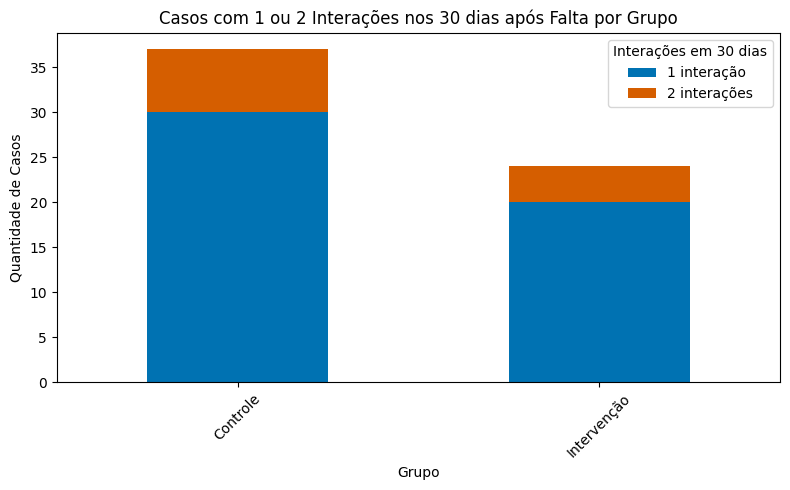

In [81]:
import matplotlib.pyplot as plt

# Criar coluna INTERVENCAO_RC para facilitar a leitura
filtro_falta['INTERVENCAO_RC'] = filtro_falta['INTERVENCAO'].map({1: 'Intervenção', 0: 'Controle'})

# Filtrar apenas casos com 1 ou 2 interações nos 30 dias após a falta
filtro_plot = filtro_falta[filtro_falta['30_DIAS_APOS_FALTA'].isin([1, 2])]

# Criar tabela cruzada para gráfico empilhado
tabela = filtro_plot.groupby(['INTERVENCAO_RC', '30_DIAS_APOS_FALTA']).size().unstack(fill_value=0)

# Plotar gráfico de barras empilhadas
tabela.plot(kind='bar', stacked=True, color=['#0072B2', '#D55E00'], figsize=(8,5))
plt.title('Casos com 1 ou 2 Interações nos 30 dias após Falta por Grupo')
plt.xlabel('Grupo')
plt.ylabel('Quantidade de Casos')
plt.legend(title='Interações em 30 dias', labels=['1 interação', '2 interações'])
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [65]:
# Cria coluna INTERVENCAO_RC se ainda não existir
filtro_falta['INTERVENCAO_RC'] = filtro_falta['INTERVENCAO'].map({1: 'Intervenção', 0: 'Controle'})

# Conta casos com 0 interações
contagem_0 = filtro_falta[filtro_falta['30_DIAS_APOS_FALTA'] == 0].groupby('INTERVENCAO_RC').size()

# Conta casos com 1 ou 2 interações
contagem_1_2 = filtro_falta[filtro_falta['30_DIAS_APOS_FALTA'].isin([1, 2])].groupby('INTERVENCAO_RC').size()

# Monta o dataframe final
df_o4 = pd.DataFrame({
    'INTERVENCAO_RC': contagem_0.index,
    'QTD_0_INTERACOES': contagem_0.values,
    'QTD_1_2_INTERACOES': contagem_1_2.reindex(contagem_0.index, fill_value=0).values
})

df_o4

/tmp/ipykernel_16289/3386195323.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtro_falta['INTERVENCAO_RC'] = filtro_falta['INTERVENCAO'].map({1: 'Intervenção', 0: 'Controle'})


,INTERVENCAO_RC,QTD_0_INTERACOES,QTD_1_2_INTERACOES
0,Controle,712,37
1,Intervenção,190,24


In [66]:
from scipy.stats import chi2_contingency

# Monta a tabela de contingência
contingencia = df_o4[['QTD_0_INTERACOES', 'QTD_1_2_INTERACOES']].values

# Teste do Qui-Quadrado
chi2, p, dof, expected = chi2_contingency(contingencia)

print(f"Qui-Quadrado: {chi2:.4f}")
print(f"p-valor: {p:.4f}")
print(f"Graus de liberdade: {dof}")
print("Frequências esperadas:")
print(expected)

Qui-Quadrado: 10.0140
p-valor: 0.0016
Graus de liberdade: 1
Frequências esperadas:
[[701.55555556  47.44444444]
 [200.44444444  13.55555556]]


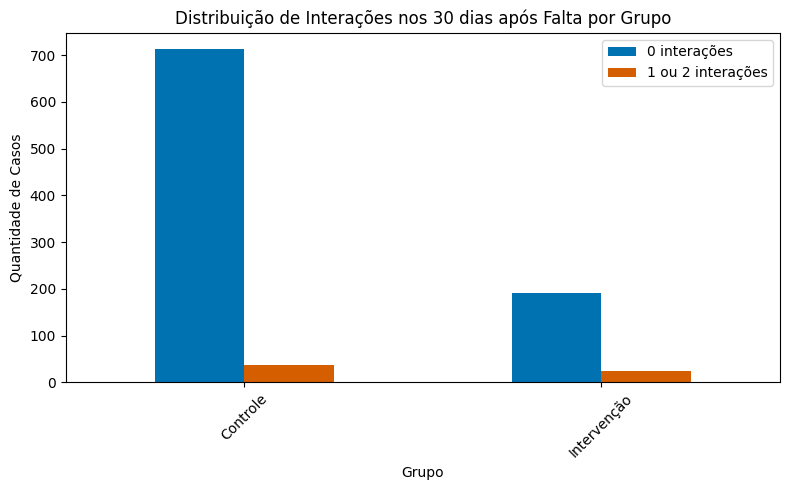

In [80]:
import matplotlib.pyplot as plt

# Gráfico de colunas agrupadas para df_o4
df_o4.set_index('INTERVENCAO_RC')[['QTD_0_INTERACOES', 'QTD_1_2_INTERACOES']].plot(
    kind='bar',
    figsize=(8,5),
    color=['#0072B2', '#D55E00']
)
plt.title('Distribuição de Interações nos 30 dias após Falta por Grupo')
plt.xlabel('Grupo')
plt.ylabel('Quantidade de Casos')
plt.legend(['0 interações', '1 ou 2 interações'])
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

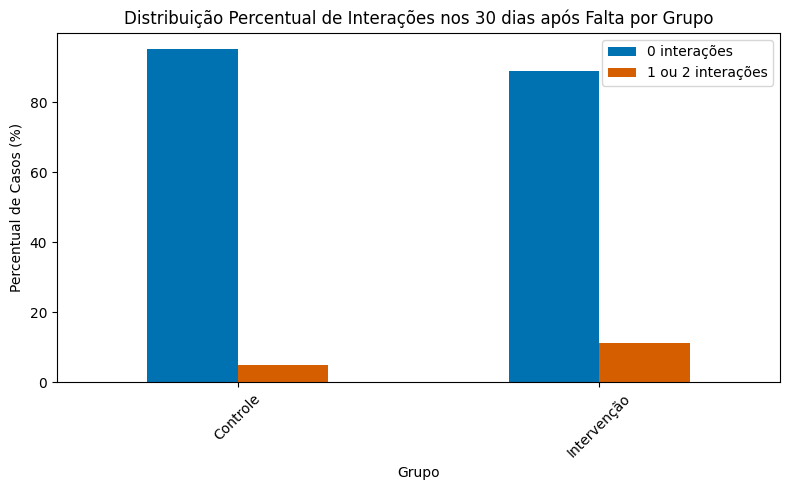

In [79]:
import matplotlib.pyplot as plt

# Calcula os percentuais para cada grupo
df_o4_percent = df_o4.copy()
total_por_grupo = df_o4_percent[['QTD_0_INTERACOES', 'QTD_1_2_INTERACOES']].sum(axis=1)
df_o4_percent['%_0_INTERACOES'] = df_o4_percent['QTD_0_INTERACOES'] / total_por_grupo * 100
df_o4_percent['%_1_2_INTERACOES'] = df_o4_percent['QTD_1_2_INTERACOES'] / total_por_grupo * 100

# Gráfico de barras agrupadas em porcentagem
df_o4_percent.set_index('INTERVENCAO_RC')[['%_0_INTERACOES', '%_1_2_INTERACOES']].plot(
    kind='bar',
    figsize=(8,5),
    color=['#0072B2', '#D55E00']
)
plt.title('Distribuição Percentual de Interações nos 30 dias após Falta por Grupo')
plt.xlabel('Grupo')
plt.ylabel('Percentual de Casos (%)')
plt.legend(['0 interações', '1 ou 2 interações'])
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

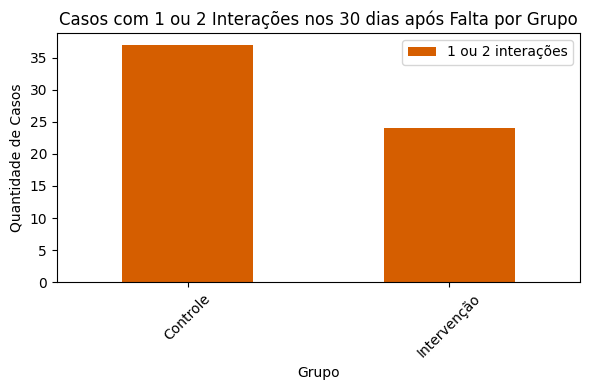

In [83]:
import matplotlib.pyplot as plt

# Filtra apenas os grupos com 1 ou 2 interações
df_o4_1_2 = df_o4.copy()
df_o4_1_2 = df_o4_1_2[df_o4_1_2['QTD_1_2_INTERACOES'] > 0]

# Gráfico de barras apenas para 1 ou 2 interações
df_o4_1_2.set_index('INTERVENCAO_RC')[['QTD_1_2_INTERACOES']].plot(
    kind='bar',
    figsize=(6,4),
    color=['#D55E00']
)
plt.title('Casos com 1 ou 2 Interações nos 30 dias após Falta por Grupo')
plt.xlabel('Grupo')
plt.ylabel('Quantidade de Casos')
plt.legend(['1 ou 2 interações'])
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [74]:
# Calcula o total por grupo
df_o4['PERC_0_INTERACOES'] = df_o4['QTD_0_INTERACOES'] / (df_o4['QTD_0_INTERACOES'] + df_o4['QTD_1_2_INTERACOES'])
df_o4['PERC_1_2_INTERACOES'] = df_o4['QTD_1_2_INTERACOES'] / (df_o4['QTD_0_INTERACOES'] + df_o4['QTD_1_2_INTERACOES'])

# Exibe a tabela atualizada
df_o4

,INTERVENCAO_RC,QTD_0_INTERACOES,QTD_1_2_INTERACOES,PERC_0_INTERACOES,PERC_1_2_INTERACOES
0,Controle,712,37,0.950601,0.049399
1,Intervenção,190,24,0.887850,0.112150


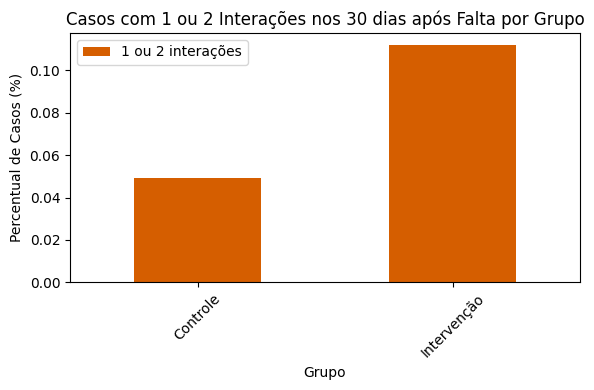

In [82]:
import matplotlib.pyplot as plt

# Filtra apenas os grupos com 1 ou 2 interações
df_o4_1_2 = df_o4.copy()
df_o4_1_2 = df_o4_1_2[df_o4_1_2['PERC_1_2_INTERACOES'] > 0]

# Gráfico de barras apenas para 1 ou 2 interações
df_o4_1_2.set_index('INTERVENCAO_RC')[['PERC_1_2_INTERACOES']].plot(
    kind='bar',
    figsize=(6,4),
    color=['#D55E00']
)
plt.title('Casos com 1 ou 2 Interações nos 30 dias após Falta por Grupo')
plt.xlabel('Grupo')
plt.ylabel('Percentual de Casos (%)')
plt.legend(['1 ou 2 interações'])
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()